### Import Main Dataset From CDC Website

In [1]:
import numpy as np
import pandas as pd

datafile = "ecolioutbreakdata.csv"
data_raw = pd.read_csv(datafile)
data_trimmed = data_raw.loc[:,['Year', 'Month', 'State', 
                      'Primary Mode', 'Serotype or Genotype', 'Illnesses', 
                      'Hospitalizations', 'Deaths']]

In [2]:
data_trimmed.head()

,Year,Month,State,Primary Mode,Serotype or Genotype,Illnesses,Hospitalizations,Deaths
0,2009,1,Massachusetts,Food,O157:H7,3,2.0,0.0
1,2009,3,Connecticut,Food,O157:H7,60,5.0,0.0
2,2009,4,Ohio,Food,O157:H7,3,2.0,0.0
3,2009,6,Minnesota,Food,O157:H7,4,0.0,0.0
4,2009,5,Wisconsin,Food,NaN,8,0.0,0.0


In [3]:
len(data_trimmed)

984

In [4]:
#assuming that outbreaks that occurred during the same month/year in the same state are related
#reduces number of outbreaks from 984 to 837
outbreaks_combined = data_trimmed.copy()
outbreaks_combined["Outbreak ID"] = (outbreaks_combined['Year'].astype(str) + ' ' + 
                                     outbreaks_combined['Month'].astype(str) + ' ' + 
                                     outbreaks_combined['State'])
outbreaks_combined_grp = outbreaks_combined.groupby('Outbreak ID')['Illnesses', 'Hospitalizations', 'Deaths'].sum().reset_index()

#I originally thought that lines could be combined on Outbreak ID, but Strain column makes each row unique
outbreaks_combined_grp = (outbreaks_combined_grp
                          .merge(outbreaks_combined
                            .drop(['Illnesses', 'Hospitalizations', 'Deaths'], axis=1), on='Outbreak ID', how='left'))

In [5]:
#check for NaNs
outbreaks_combined_grp.isnull().values.any()

True

In [6]:
#clean up Serotype or Genotype (Strain) column
unique_strain = outbreaks_combined.copy()
unique_strain = unique_strain.rename(index=str, columns={'Serotype or Genotype':'Strain'})
unique_strain = unique_strain[pd.notnull(unique_strain['Strain'])]

In [7]:
len(unique_strain)

940

In [8]:
#separate out strains into their own rows when there are multiple strains listed
strain_sep = (unique_strain.drop('Strain', axis=1)
             .join
             (
             unique_strain.Strain
             .str
             .split(expand=True)
             .stack()
             .reset_index(drop=True, level=1)
             .rename('Strain')           
             ))
strain_sep['Strain'] = strain_sep['Strain'].map(lambda x: x.rstrip(';'))

In [9]:
strain_sep['Primary Mode'] = strain_sep['Primary Mode'].str.replace('Indeterminate/Other/Unknown', 'Other')
strain_sep['Primary Mode'] = strain_sep['Primary Mode'].str.replace('Person-to-person', 'Other')
strain_sep['Primary Mode'] = strain_sep['Primary Mode'].str.replace('Animal Contact', 'Other')
strain_sep['Primary Mode'] = strain_sep['Primary Mode'].str.replace('Water', 'Other')
strain_sep['Primary Mode'] = strain_sep['Primary Mode'].str.replace('Environmental contamination other than food/water', 'Other')

In [10]:
strain_sep.head()

,Year,Month,State,Primary Mode,Illnesses,Hospitalizations,Deaths,Outbreak ID,Strain
0,2009,1,Massachusetts,Food,3,2.0,0.0,2009 1 Massachusetts,O157:H7
1,2009,3,Connecticut,Food,60,5.0,0.0,2009 3 Connecticut,O157:H7
10,2009,7,Ohio,Other,3,1.0,0.0,2009 7 Ohio,O157:H7
100,2010,7,Massachusetts,Other,2,2.0,0.0,2010 7 Massachusetts,O157:H7
101,2011,5,Louisiana,Other,8,4.0,0.0,2011 5 Louisiana,O157:H7


### Bring in population density and human development index from Wikipedia

In [11]:
url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population_density'
pop_dens_raw = pd.read_html(url, header=0)[0]
pop_dens_raw = pop_dens_raw.loc[:,['State', 'Density (Pop./ mi2)', 'Landarea(mi2)']]

url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_Human_Development_Index'
HDI_raw = pd.read_html(url, header=0)[0]
HDI_raw = HDI_raw.rename(index=str, columns={'Statefederal district or territory':'State'})
HDI_raw = HDI_raw.loc[:,['State', 'HDI (2017)[note 1]', 'HDI (1995)']]

In [12]:
strain_state = pd.merge(strain_sep, pop_dens_raw, on='State')
strain_state = pd.merge(strain_state, HDI_raw, on='State')

In [13]:
strain_state["State"].unique()

array(['Massachusetts', 'Connecticut', 'Ohio', 'Louisiana', 'New York',
       'Arizona', 'Colorado', 'Idaho', 'Oregon', 'Wisconsin', 'Tennessee',
       'Missouri', 'Alabama', 'Maryland', 'Washington', 'Michigan',
       'Minnesota', 'Pennsylvania', 'New Hampshire', 'Utah',
       'North Carolina', 'Maine', 'Kansas', 'Georgia', 'Virginia',
       'South Dakota', 'Texas', 'Kentucky', 'South Carolina', 'Illinois',
       'California', 'Wyoming', 'Montana', 'Iowa', 'Oklahoma',
       'Mississippi', 'Florida', 'Nevada', 'Indiana', 'Hawaii',
       'Arkansas', 'New Mexico', 'Rhode Island', 'Nebraska', 'Alaska',
       'North Dakota', 'New Jersey', 'Vermont', 'West Virginia'],
      dtype=object)

### Scrape from US Climate Data for avg. high/low temp per month per state

In [14]:
import time
import random

In [15]:
#make list of Climate Data urls
states = np.ndarray.tolist(strain_state["State"].unique())
climate_urls = []
for state in states:
    climate_urls.append("https://www.usclimatedata.com/climate/"+state+"/united-states/")

In [16]:
tables = pd.read_html("https://www.usclimatedata.com/climate/Massachusetts/united-states/")
climate_raw = (pd.concat([tables[0][0:2].transpose(), 
                          tables[1][0:2].transpose()]))
climate_raw = (climate_raw.drop(climate_raw.index[[0,7]])
               .rename({0:'Average High (F)', 1:'Average Low (F)'}, axis='columns'))
string = 'Massachusetts' + ' '
climate_raw['state_month'] = [string+str(i) for i in range(12)]

In [17]:
all_climates = pd.DataFrame()
for idx, url in enumerate(climate_urls):
    url = url.replace(' ', '%20')
    tables = pd.read_html(url)
    climate_raw = (pd.concat([tables[0][0:2].transpose(), 
                          tables[1][0:2].transpose()]))
    climate_raw = (climate_raw.drop(climate_raw.index[[0,7]])
               .rename({0:'Average High (F)', 1:'Average Low (F)'}, axis='columns')).reset_index()
    string = states[idx] + ' '
    climate_raw['state_month'] = [string+str(i) for i in range(12)]
    all_climates = pd.concat([all_climates, climate_raw])
    #time.sleep(30)

In [18]:
all_climates.head()

,index,Average High (F),Average Low (F),state_month
0,Jan,36,22,Massachusetts 0
1,Feb,39,25,Massachusetts 1
2,Mar,45,31,Massachusetts 2
3,Apr,56,41,Massachusetts 3
4,May,66,50,Massachusetts 4


In [19]:
strain_state_cli = strain_state
strain_state_cli["state_month"] = (strain_state['State'] + ' ' + 
                                     strain_state['Month'].astype(str))

In [20]:
strain_state_cli = pd.merge(strain_state_cli, all_climates, on='state_month')

In [21]:
strain_state_cli.head()

,Year,Month,State,Primary Mode,Illnesses,Hospitalizations,Deaths,Outbreak ID,Strain,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],HDI (1995),state_month,index,Average High (F),Average Low (F)
0,2009,1,Massachusetts,Food,3,2.0,0.0,2009 1 Massachusetts,O157:H7,871,7800,0.96,0.905,Massachusetts 1,Feb,39,25
1,2010,7,Massachusetts,Other,2,2.0,0.0,2010 7 Massachusetts,O157:H7,871,7800,0.96,0.905,Massachusetts 7,Aug,80,65
2,2011,7,Massachusetts,Other,8,3.0,0.0,2011 7 Massachusetts,O157:H7,871,7800,0.96,0.905,Massachusetts 7,Aug,80,65
3,2002,7,Massachusetts,Food,5,3.0,0.0,2002 7 Massachusetts,O157:NM,871,7800,0.96,0.905,Massachusetts 7,Aug,80,65
4,2002,7,Massachusetts,Food,5,3.0,0.0,2002 7 Massachusetts,(H-),871,7800,0.96,0.905,Massachusetts 7,Aug,80,65


In [22]:
strain_state_cli = strain_state_cli.drop('index', axis=1)
strain_state_cli = strain_state_cli.drop('state_month', axis=1)

In [23]:
datafile = "strain_state_cli.csv"
strain_state_cli.to_csv(datafile, index=True, header=True)

### Selenium scrape NCBI for additional data

*See Notebook "Selenium NCBI Scrape"*

In [24]:
datafile = "all_terms.csv"
all_terms = pd.read_csv(datafile)

In [25]:
#check for NaNs
all_terms.isnull().values.any()

True

In [26]:
all_terms.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Year', 'Month', 'State', 'Primary Mode',
       'Illnesses', 'Hospitalizations', 'Deaths', 'Outbreak ID', 'Strain',
       'Density (Pop./ mi2)', 'Landarea(mi2)', 'HDI (2017)[note 1]',
       'HDI (1995)', 'Average High (F)', 'Average Low (F)', 'Length of Genome',
       '%GC', 'Protein Coding Genes', 'Genes Overall', 'tRNA Genes'],
      dtype='object')

In [27]:
#check each column individually for NAs
all_terms.loc[:,"tRNA Genes"].isnull().values.any()

False

In [28]:
#How many unique strains?
all_terms.loc[:,"Strain"].unique()

array(['O157:H7', 'O157:NM', 'O26', 'O121', 'O45:H2', 'O157', 'O103',
       'O111', 'O146:H21', 'O6:H16', 'O111:NM', 'O26:H11', 'O118:H16'],
      dtype=object)

In [29]:
#NAs are in "Hospitalizations", "Deaths", decided to drop columns anyway
no_na_terms = all_terms.drop(["Hospitalizations", "Deaths"], axis=1)

In [30]:
no_na_terms.isnull().values.any()

False

In [31]:
len(no_na_terms)

747

In [32]:
no_na_terms.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Year', 'Month', 'State', 'Primary Mode',
       'Illnesses', 'Outbreak ID', 'Strain', 'Density (Pop./ mi2)',
       'Landarea(mi2)', 'HDI (2017)[note 1]', 'HDI (1995)', 'Average High (F)',
       'Average Low (F)', 'Length of Genome', '%GC', 'Protein Coding Genes',
       'Genes Overall', 'tRNA Genes'],
      dtype='object')

In [33]:
#making sure that all columns were the proper type
no_na_terms.dtypes

Unnamed: 0                int64
Unnamed: 0.1              int64
Year                      int64
Month                     int64
State                    object
Primary Mode             object
Illnesses                 int64
Outbreak ID              object
Strain                   object
Density (Pop./ mi2)       int64
Landarea(mi2)            object
HDI (2017)[note 1]      float64
HDI (1995)              float64
Average High (F)        float64
Average Low (F)         float64
Length of Genome        float64
%GC                     float64
Protein Coding Genes     object
Genes Overall            object
tRNA Genes                int64
dtype: object

In [34]:
# columns scraped from selenium had commas in it and couldn't be converted to int
no_na_terms.loc[:,'Protein Coding Genes'] = (no_na_terms.loc[:,'Protein Coding Genes']
                                              .str.replace(',', '')
                                              .astype(float))
no_na_terms.loc[:,'Genes Overall'] = (no_na_terms.loc[:,'Genes Overall']
                                             .str.replace(',', '')
                                             .astype(float))

In [35]:
# California had a weird value for Landarea
#no_na_terms.loc[:,'Landarea(mi2)'] = no_na_terms.loc[:,'Landarea(mi2)'].astype(int)
#no_na_terms.loc[no_na_terms['Landarea(mi2)'] == '155,959[5]'].head()

In [36]:
no_na_terms = no_na_terms.replace('155,959[5]', 155959)

In [37]:
no_na_terms.loc[:,'Year'] = no_na_terms.loc[:,'Year'].astype(str)
no_na_terms.loc[:,'Month'] = no_na_terms.loc[:,'Month'].astype(str)
no_na_terms.loc[:,'HDI (1995)'] = no_na_terms.loc[:,'HDI (1995)'].astype(float)
no_na_terms.loc[:,'Average High (F)'] = no_na_terms.loc[:,'Average High (F)'].astype(int)
no_na_terms.loc[:,'Average Low (F)'] = no_na_terms.loc[:,'Average Low (F)'].astype(int)
no_na_terms.loc[:,'Length of Genome'] = no_na_terms.loc[:,'Length of Genome'].astype(float)
no_na_terms.loc[:,'%GC'] = no_na_terms.loc[:,'%GC'].astype(float)
no_na_terms.loc[:,'Protein Coding Genes'] = no_na_terms.loc[:,'Protein Coding Genes'].astype(int)
no_na_terms.loc[:,'Genes Overall'] = no_na_terms.loc[:,'Genes Overall'].astype(int)
no_na_terms.loc[:,'tRNA Genes'] = no_na_terms.loc[:,'tRNA Genes'].astype(int)
no_na_terms.loc[:,'Landarea(mi2)'] = no_na_terms.loc[:,'Landarea(mi2)'].astype(int)

In [38]:
no_na_terms.shape

(747, 20)

In [39]:
no_na_terms = no_na_terms.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [40]:
no_na_terms.head()

,Year,Month,State,Primary Mode,Illnesses,Outbreak ID,Strain,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],HDI (1995),Average High (F),Average Low (F),Length of Genome,%GC,Protein Coding Genes,Genes Overall,tRNA Genes
0,2009,1,Massachusetts,Food,3,2009 1 Massachusetts,O157:H7,871,7800,0.96,0.905,39,25,5.59,50.45,5155,5417,103
1,2010,7,Massachusetts,Other,2,2010 7 Massachusetts,O157:H7,871,7800,0.96,0.905,80,65,5.59,50.45,5155,5417,103
2,2011,7,Massachusetts,Other,8,2011 7 Massachusetts,O157:H7,871,7800,0.96,0.905,80,65,5.59,50.45,5155,5417,103
3,2012,4,Massachusetts,Food,2,2012 4 Massachusetts,O157:H7,871,7800,0.96,0.905,66,50,5.59,50.45,5155,5417,103
4,2012,5,Massachusetts,Food,6,2012 5 Massachusetts,O157:H7,871,7800,0.96,0.905,76,60,5.59,50.45,5155,5417,103


In [41]:
datafile = "no_na_terms.csv"
no_na_terms.to_csv(datafile, index=True, header=True)

### EDA

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

I wanted to see what the average values of each (relevant) column were:

In [43]:
no_na_terms.describe()

,Illnesses,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],HDI (1995),Average High (F),Average Low (F),Length of Genome,%GC,Protein Coding Genes,Genes Overall,tRNA Genes
count,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,13.879518,183.048193,74425.574297,0.929246,0.883027,72.453815,51.776439,5.579558,50.472035,5229.270415,5549.078983,101.737617
std,38.645380,189.622584,59689.979381,0.018203,0.016764,14.225829,13.068066,0.115370,0.083838,194.593422,274.879741,3.518731
min,2.000000,1.000000,1034.000000,0.866000,0.825000,29.000000,13.000000,4.970000,50.200000,4627.000000,5144.000000,77.000000
25%,3.000000,57.000000,44743.000000,0.916000,0.874000,63.000000,43.000000,5.590000,50.450000,5155.000000,5417.000000,103.000000
50%,5.000000,107.000000,66456.000000,0.933000,0.882000,76.000000,53.000000,5.590000,50.450000,5155.000000,5417.000000,103.000000
75%,12.000000,251.000000,82643.000000,0.945000,0.901000,83.000000,63.000000,5.590000,50.450000,5155.000000,5417.000000,103.000000
max,736.000000,1218.000000,570641.000000,0.960000,0.912000,106.000000,83.000000,5.860000,50.700000,5906.000000,6377.000000,103.000000


Since I'm using the Illnesses column as my Y, I decided to do some basic statistics and create some plots to look at the distribution of Y values

In [44]:
no_na_terms.loc[:,"Illnesses"].describe()

count    747.000000
mean      13.879518
std       38.645380
min        2.000000
25%        3.000000
50%        5.000000
75%       12.000000
max      736.000000
Name: Illnesses, dtype: float64

In [45]:
no_na_terms.loc[:,"Illnesses"].median()

5.0

In [46]:
no_na_terms.loc[:,"Illnesses"].mode()

0    2
dtype: int64

Given that the max value of illnesses is 736, and the median and mode are very low (5 and 2), I suspected that there must be a few very high outliers

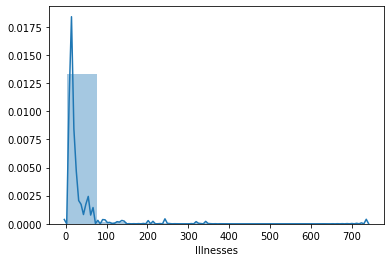

In [47]:
sns.distplot(no_na_terms.loc[:,"Illnesses"],bins=10,norm_hist=True)

Text(0.5, 1.0, 'Distribution of Illnesses Per Outbreak')

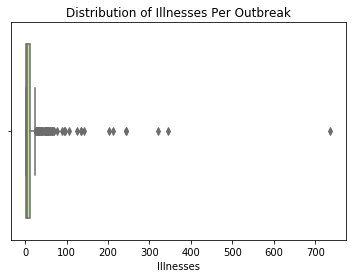

In [146]:
sns.boxplot(no_na_terms.loc[:,"Illnesses"], color="#C2F970").set_title('Distribution of Illnesses Per Outbreak')

In [49]:
no_na_terms.sort_values(by='Illnesses', ascending=False)

,Year,Month,State,Primary Mode,Illnesses,Outbreak ID,Strain,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],HDI (1995),Average High (F),Average Low (F),Length of Genome,%GC,Protein Coding Genes,Genes Overall,tRNA Genes
161,2000,7,Wisconsin,Food,736,2000 7 Wisconsin,O157:H7,106,54158,0.932,0.886,78,63,5.59,50.45,5155,5417,103
724,2008,8,Oklahoma,Food,344,2008 8 Oklahoma,O111,57,68595,0.899,0.858,85,63,5.28,50.59,5155,5615,100
441,1999,9,Illinois,Food,321,1999 9 Illinois,O157:H7,231,55519,0.933,0.883,63,46,5.59,50.45,5155,5417,103
672,2017,10,California,Food,244,2017 10 California,O157,251,155959,0.934,0.882,64,43,5.75,50.43,5646,6129,100
615,2017,10,California,Food,244,2017 10 California,O26,251,155959,0.934,0.882,64,43,5.74,50.65,5723,6240,101
699,2004,9,New York,Food,212,2004 9 New York,O111,420,47126,0.946,0.888,65,50,5.28,50.59,5155,5615,100
377,2001,11,North Carolina,Food,202,2001 11 North Carolina,O157:H7,206,48618,0.909,0.861,53,32,5.59,50.45,5155,5417,103
374,1998,7,North Carolina,Food,143,1998 7 North Carolina,O157:H7,206,48618,0.909,0.861,87,67,5.59,50.45,5155,5417,103
589,2007,7,Colorado,Food,135,2007 7 Colorado,O26,52,103642,0.947,0.906,88,57,5.74,50.65,5723,6240,101
626,2007,7,Colorado,Food,135,2007 7 Colorado,O121,52,103642,0.947,0.906,88,57,5.47,50.63,5282,5822,101


I'll repeat these only considering values less than 200, this got rid of 7 rows

In [50]:
ill_lt200 = no_na_terms[no_na_terms.loc[:,"Illnesses"] < 200]

In [51]:
len(ill_lt200)

740

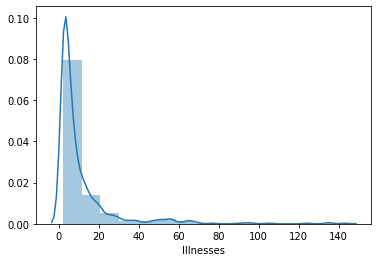

In [52]:
sns.distplot(ill_lt200.loc[:,"Illnesses"],bins=15,norm_hist=True)

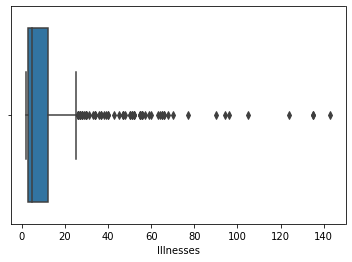

In [53]:
sns.boxplot(ill_lt200.loc[:,"Illnesses"])

Try again with values < 80

In [54]:
ill_lt80 = no_na_terms[no_na_terms.loc[:,"Illnesses"] < 80]

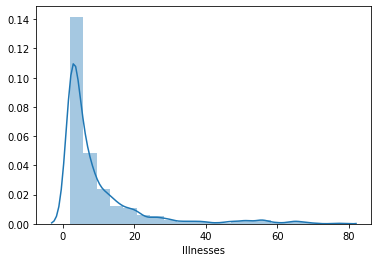

In [55]:
sns.distplot(ill_lt80.loc[:,"Illnesses"],bins=20,norm_hist=True)

Text(0.5, 1.0, 'Distribution of Illnesses Per Outbreak')

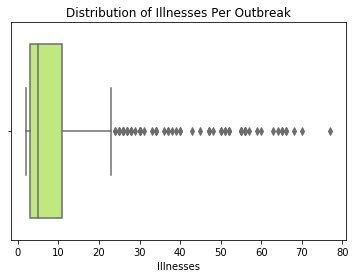

In [145]:
sns.boxplot(ill_lt80.loc[:,"Illnesses"], color='#C2F970').set_title('Distribution of Illnesses Per Outbreak')

run stats as before on the < 80 data

In [57]:
ill_lt80.describe()

,Illnesses,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],HDI (1995),Average High (F),Average Low (F),Length of Genome,%GC,Protein Coding Genes,Genes Overall,tRNA Genes
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,9.758197,183.035519,74212.894809,0.929306,0.883101,72.360656,51.706284,5.579727,50.471339,5228.396175,5547.469945,101.732240
std,12.321514,191.030616,59987.209132,0.018254,0.016802,14.232522,13.077160,0.114934,0.083698,194.040010,273.883233,3.549825
min,2.000000,1.000000,1034.000000,0.866000,0.825000,29.000000,13.000000,4.970000,50.200000,4627.000000,5144.000000,77.000000
25%,3.000000,57.000000,44743.000000,0.916000,0.874000,63.000000,43.000000,5.590000,50.450000,5155.000000,5417.000000,103.000000
50%,5.000000,107.000000,66456.000000,0.933000,0.882000,76.000000,53.000000,5.590000,50.450000,5155.000000,5417.000000,103.000000
75%,11.000000,251.000000,82170.000000,0.945000,0.901000,83.000000,63.000000,5.590000,50.450000,5155.000000,5417.000000,103.000000
max,77.000000,1218.000000,570641.000000,0.960000,0.912000,106.000000,83.000000,5.860000,50.700000,5906.000000,6377.000000,103.000000


### Linear Regression Analysis

##### Model Guide:
X--------------------------------------------------------------Base model<br>
Xh-------------------------------------------------------------Highest corr features from base model<br>
X2-------------------------------------------------------------Strain Dummy Variables<br>
X3-------------------------------------------------------------Year Dummy Variables (omitted)<br>
X4-------------------------------------------------------------State Dummy Variables (omitted)<br>
X5-------------------------------------------------------------Year and State Dummies (omitted)<br>
section(8.1)---------------------------------------------------Log transform y***<br>
X6-------------------------------------------------------------Log transform Density and Land area<br>
section(8.3)---------------------------------------------------Log transform Both<br>
X7-------------------------------------------------------------X6 log(y) and State dummy (omitted)<br>
section(9)-----------------------------------------------------Ridge/Lasso on base model<br>
X8-------------------------------------------------------------Region dummies<br>
X9-------------------------------------------------------------Dummy Region and Strain<br>
X_o------------------------------------------------------------Remove >200 outliers<br>
X_o2-----------------------------------------------------------Remove >80 outliers

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import RidgeCV

In [59]:
no_na_terms.corr()

,Illnesses,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],HDI (1995),Average High (F),Average Low (F),Length of Genome,%GC,Protein Coding Genes,Genes Overall,tRNA Genes
Illnesses,1.000000,-0.008129,0.030959,0.003564,-0.006155,0.036437,0.043838,-0.041879,0.027117,-0.005519,0.007588,-0.009420
Density (Pop./ mi2),-0.008129,1.000000,-0.363658,0.223319,0.086496,-0.048039,0.084840,0.010304,-0.067094,-0.017103,-0.020819,-0.029668
Landarea(mi2),0.030959,-0.363658,1.000000,0.056635,0.133688,0.056950,-0.044242,0.010524,-0.027653,-0.014533,-0.018014,0.011655
HDI (2017)[note 1],0.003564,0.223319,0.056635,1.000000,0.937945,-0.115127,-0.069342,-0.059522,-0.026637,-0.002076,0.024859,-0.094550
HDI (1995),-0.006155,0.086496,0.133688,0.937945,1.000000,-0.131072,-0.110919,-0.028396,0.001201,0.033808,0.056763,-0.084870
Average High (F),0.036437,-0.048039,0.056950,-0.115127,-0.131072,1.000000,0.936232,-0.044979,-0.027222,-0.023411,-0.022706,-0.019577
Average Low (F),0.043838,0.084840,-0.044242,-0.069342,-0.110919,0.936232,1.000000,-0.062979,-0.043410,-0.055506,-0.053631,-0.008011
Length of Genome,-0.041879,0.010304,0.010524,-0.059522,-0.028396,-0.044979,-0.062979,1.000000,0.106571,0.617307,0.403440,0.428717
%GC,0.027117,-0.067094,-0.027653,-0.026637,0.001201,-0.027222,-0.043410,0.106571,1.000000,0.392653,0.463630,0.269724
Protein Coding Genes,-0.005519,-0.017103,-0.014533,-0.002076,0.033808,-0.023411,-0.055506,0.617307,0.392653,1.000000,0.963548,-0.219053


It looks like the HDI columns are highly correlated, as well as average high/low temps and PCD and GO. This was expected.

In [60]:
no_autocorr = no_na_terms.drop(['HDI (1995)', 'Average Low (F)'], axis=1)

In [61]:
# made another column that is %PCG compared to genes overall
no_autocorr["%Protein Coding"] = (no_autocorr["Protein Coding Genes"]/no_autocorr["Genes Overall"])*100

In [62]:
no_autocorr = no_autocorr.drop(['Protein Coding Genes', 'Genes Overall'], axis=1)

In [63]:
no_autocorr.isnull().values.any()

False

In [64]:
no_autocorr.head()

,Year,Month,State,Primary Mode,Illnesses,Outbreak ID,Strain,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],Average High (F),Length of Genome,%GC,tRNA Genes,%Protein Coding
0,2009,1,Massachusetts,Food,3,2009 1 Massachusetts,O157:H7,871,7800,0.96,39,5.59,50.45,103,95.163375
1,2010,7,Massachusetts,Other,2,2010 7 Massachusetts,O157:H7,871,7800,0.96,80,5.59,50.45,103,95.163375
2,2011,7,Massachusetts,Other,8,2011 7 Massachusetts,O157:H7,871,7800,0.96,80,5.59,50.45,103,95.163375
3,2012,4,Massachusetts,Food,2,2012 4 Massachusetts,O157:H7,871,7800,0.96,66,5.59,50.45,103,95.163375
4,2012,5,Massachusetts,Food,6,2012 5 Massachusetts,O157:H7,871,7800,0.96,76,5.59,50.45,103,95.163375


In [65]:
no_autocorr.dtypes

Year                    object
Month                   object
State                   object
Primary Mode            object
Illnesses                int64
Outbreak ID             object
Strain                  object
Density (Pop./ mi2)      int64
Landarea(mi2)            int64
HDI (2017)[note 1]     float64
Average High (F)         int64
Length of Genome       float64
%GC                    float64
tRNA Genes               int64
%Protein Coding        float64
dtype: object

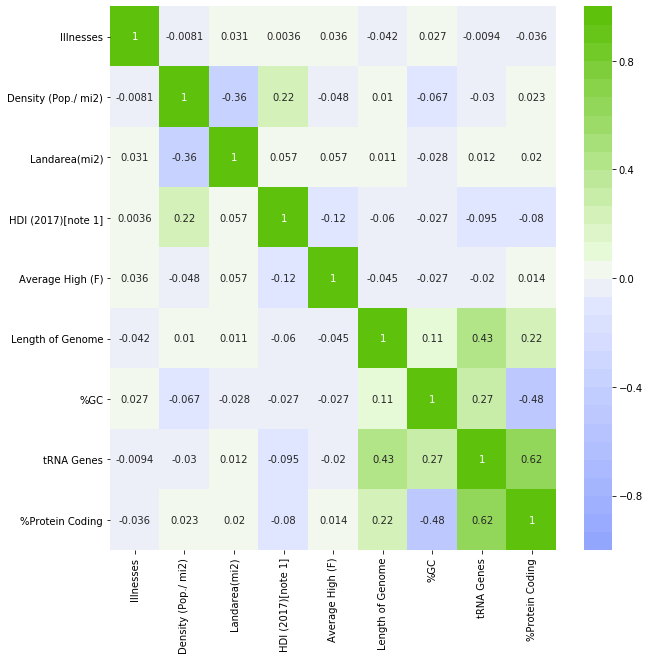

In [66]:
#a heatmap of correlations with autocorrelated variables removed
plt.figure(figsize = (10,10))
sns.heatmap(no_autocorr.corr(), cmap=sns.diverging_palette(-100, 120, s=99, l=70, sep=9, n=30), annot=True, vmin=-1, vmax=1);

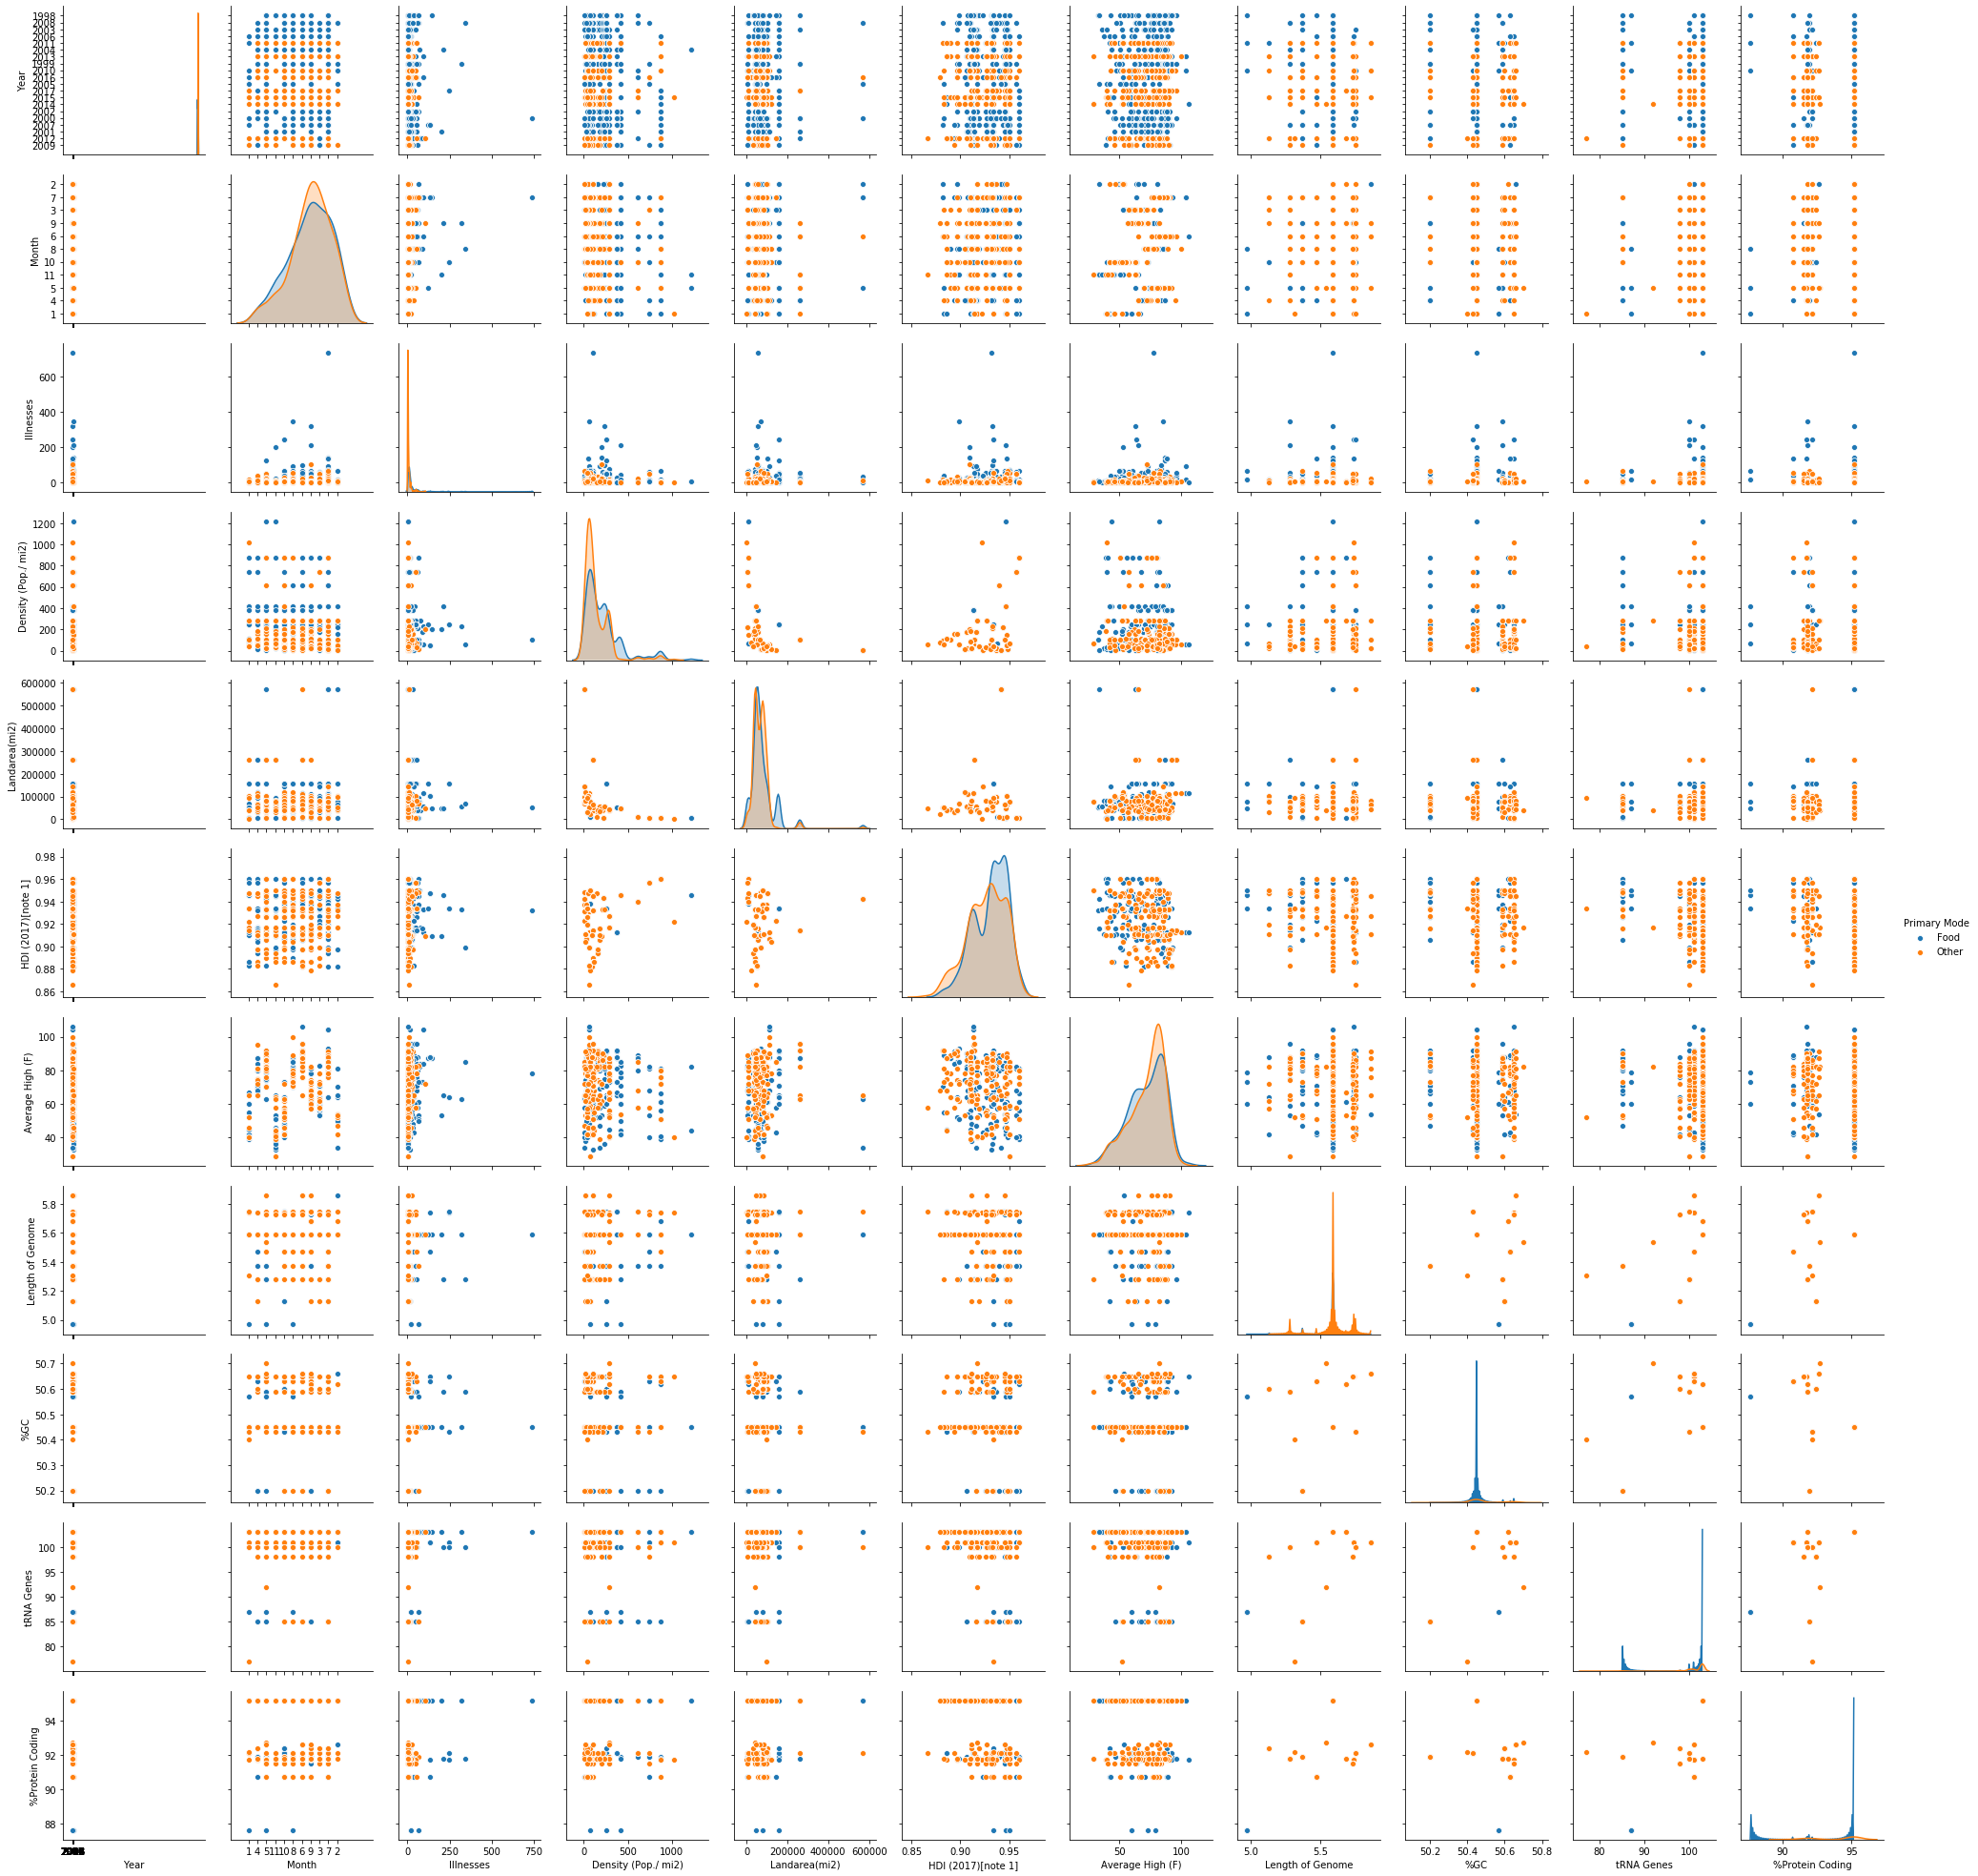

In [67]:
sns.pairplot(no_autocorr, hue='Primary Mode')

In [68]:
# make a function that calculates adjusted R^2
def adjusted_r_squared(X, y):
    adj_r2 = 1 - (1-lr.score(X,y))*(len(y)-1)/(len(y)-X.shape[1]-1)
    print(adj_r2)

#### Base Model

In [69]:
lr = LinearRegression()
X = (no_autocorr.loc[:, ['Density (Pop./ mi2)', 'Landarea(mi2)', 
                         'HDI (2017)[note 1]', 'Average High (F)', 
                         'Length of Genome', '%GC', 'tRNA Genes', '%Protein Coding']])
y = no_autocorr.loc[:, 'Illnesses']

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.0058807777148689455

In [70]:
adjusted_r_squared(X, y)

-0.004895582418303235


#### Fitting only on "highest" correlated variables

In [71]:
Xh = (no_autocorr.loc[:, ['Landarea(mi2)', 'Average High (F)','%GC']])
y = no_autocorr.loc[:, 'Illnesses']

lr.fit(Xh, y)

lr.score(Xh,y)

0.002999114912152545

In [72]:
adjusted_r_squared(Xh, y)

-0.0010264606669370124


Unsuccessful -_-

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
#train/val/test function from feature_engineering_regression notebook
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('Train Score: ', train_score)
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [75]:
split_and_validate(X, y)

Train Score:  0.002229220383803021

Validation R^2 score was: 0.003375319459196668
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 30.28
Average High (F) : 0.04
Length of Genome : -3.64
%GC : 0.64
tRNA Genes : 0.18
%Protein Coding : -0.29


### Add Dummy Variables

#### Try adding dummy variables for Strain

In [76]:
X2 = X.copy()
X2['Strain'] = no_autocorr['Strain']
X2 = pd.get_dummies(X2)

In [77]:
lr.fit(X2, y)

lr.score(X2,y)

0.008455151135092764

In [78]:
adjusted_r_squared(X2, y)

-0.02026545828030457


Went up 0.003...

In [79]:
split_and_validate(X2, y)

Train Score:  0.0066698087373638915

Validation R^2 score was: -0.013987169289308321
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 36.23
Average High (F) : 0.03
Length of Genome : -3.35
%GC : -2.31
tRNA Genes : 0.17
%Protein Coding : -2.84
Strain_O103 : -0.34
Strain_O111 : 5.12
Strain_O111:NM : -4.44
Strain_O118:H16 : -3.44
Strain_O121 : -9.42
Strain_O146:H21 : -3.73
Strain_O157 : 2.72
Strain_O157:H7 : 10.37
Strain_O157:NM : -0.23
Strain_O26 : 6.39
Strain_O26:H11 : -3.59
Strain_O45:H2 : -8.67
Strain_O6:H16 : 9.24


#### Make Dummies for Region

In [80]:
X8 = X.copy()
X8['Region'] = no_autocorr['State']
X8['Region'] = X8['Region'].replace(['Connecticut', 'Maine', 'Massachusetts', 
                                     'New Hampshire','Rhode Island', 'Vermont', 
                                     'New Jersey', 'New York', 'Pennsylvania'], 'Northeast')
X8['Region'] = X8['Region'].replace(['Illinois', 'Indiana', 'Michigan', 'Ohio', 
                                     'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 
                                     'Missouri', 'Nebraska', 'North Dakota', 
                                     'South Dakota'], 'Midwest')
X8['Region'] = X8['Region'].replace(['Delaware', 'Florida', 'Georgia', 'Maryland', 
                                     'North Carolina', 'South Carolina', 'Virginia', 
                                     'West Virginia', 'Alabama', 'Kentucky', 
                                     'Mississippi', 'Tennessee', 'Arkansas', 
                                     'Louisiana', 'Oklahoma', 'Texas'], 'South')
X8['Region'] = X8['Region'].replace(['Arizona', 'Colorado', 'Idaho', 'Montana', 
                                     'Nevada', 'New Mexico', 'Utah', 'Wyoming', 
                                     'Alaska', 'California', 'Hawaii', 'Oregon', 
                                     'Washington'], 'West')
X8 = pd.get_dummies(X8)

In [81]:
lr.fit(X8, y)

lr.score(X8,y)

0.00920414584255802

In [82]:
adjusted_r_squared(X8, y)

-0.006994151500615331


In [83]:
split_and_validate(X8, y)

Train Score:  0.006462193519645831

Validation R^2 score was: -0.005688009739232891
Feature coefficient results: 

Density (Pop./ mi2) : 0.01
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 56.39
Average High (F) : 0.04
Length of Genome : -4.07
%GC : 2.87
tRNA Genes : 0.12
%Protein Coding : -0.09
Region_Midwest : 3.95
Region_Northeast : -4.78
Region_South : 1.68
Region_West : -0.85


#### Dummy Region and Strain together

In [84]:
X9 = X8.copy()
X9['Strain'] = no_autocorr['Strain']
X9 = pd.get_dummies(X9)

In [85]:
l1 = Lasso()
l1.fit(X9,np.log(y))

l1.score(X9,np.log(y))

0.010412179474742045

In [86]:
split_and_validate(X9,np.log(y))

Train Score:  0.05387462528825126

Validation R^2 score was: -0.00012577651806333634
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 5.22
Average High (F) : 0.00
Length of Genome : -0.23
%GC : -0.09
tRNA Genes : -0.00
%Protein Coding : -0.18
Region_Midwest : 0.14
Region_Northeast : -0.34
Region_South : 0.23
Region_West : -0.04
Strain_O103 : 0.17
Strain_O111 : 0.13
Strain_O111:NM : -0.13
Strain_O118:H16 : -0.16
Strain_O121 : -0.53
Strain_O146:H21 : -0.39
Strain_O157 : -0.30
Strain_O157:H7 : 0.65
Strain_O157:NM : 0.02
Strain_O26 : -0.05
Strain_O26:H11 : 0.12
Strain_O45:H2 : -0.11
Strain_O6:H16 : 0.58


### Polynomial Transformations

#### log transform skewed data, start with y (illnesses)

In [87]:
lr.fit(X, np.log(y))

lr.score(X,np.log(y))

0.021867820758660447

In [88]:
adjusted_r_squared(X, np.log(y))

0.011264761905095844


In [89]:
split_and_validate(X, np.log(y))

Train Score:  0.019860997077038478

Validation R^2 score was: 0.016704551809082258
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 1.22
Average High (F) : 0.01
Length of Genome : -0.59
%GC : 0.81
tRNA Genes : -0.03
%Protein Coding : 0.08


Maybe best model so far. At least validated R^2 is positive here

#### log transform density and land area

In [90]:
X6 = X.copy()
X6['Density (Pop./ mi2)'] = np.log(X6['Density (Pop./ mi2)'])
X6['Landarea(mi2)'] = np.log(X6['Landarea(mi2)'])

In [91]:
lr.fit(X6, y)

lr.score(X6, y)

0.00925212280260701

In [92]:
adjusted_r_squared(X6, y)

-0.0014876915843564653


In [93]:
split_and_validate(X6, y)

Train Score:  0.007347942796639528

Validation R^2 score was: -0.006846961858250067
Feature coefficient results: 

Density (Pop./ mi2) : 3.61
Landarea(mi2) : 4.95
HDI (2017)[note 1] : 50.41
Average High (F) : 0.01
Length of Genome : -3.17
%GC : 1.06
tRNA Genes : 0.18
%Protein Coding : -0.44


#### Log transform both

In [94]:
lr.fit(X6, np.log(y))

lr.score(X6, np.log(y))

0.022092463551882324

In [95]:
adjusted_r_squared(X6, np.log(y))

0.011491839850547692


In [96]:
split_and_validate(X6, np.log(y))

Train Score:  0.021839949499254274

Validation R^2 score was: 0.004771855775421163
Feature coefficient results: 

Density (Pop./ mi2) : 0.09
Landarea(mi2) : 0.13
HDI (2017)[note 1] : 2.06
Average High (F) : 0.00
Length of Genome : -0.58
%GC : 0.82
tRNA Genes : -0.03
%Protein Coding : 0.08


#### combine log transformations and dummies for year

In [97]:
X7 = X.copy()
X7['Density (Pop./ mi2)'] = np.log(X7['Density (Pop./ mi2)'])
X7['Landarea(mi2)'] = np.log(X7['Landarea(mi2)'])

X7['Year'] = no_autocorr['Year']
X7 = pd.get_dummies(X7)

In [98]:
X7.shape

(747, 28)

In [99]:
lr.fit(X7, np.log(y))

lr.score(X7, np.log(y))

0.11429533031674433

In [100]:
adjusted_r_squared(X7, np.log(y))

0.07975531534302416


In [101]:
split_and_validate(X7, np.log(y))

Train Score:  0.13166571548923

Validation R^2 score was: -0.019182285573233315
Feature coefficient results: 

Density (Pop./ mi2) : 0.07
Landarea(mi2) : 0.12
HDI (2017)[note 1] : 1.70
Average High (F) : 0.00
Length of Genome : -0.49
%GC : 1.10
tRNA Genes : -0.03
%Protein Coding : 0.05
Year_1998 : 0.51
Year_1999 : 0.47
Year_2000 : 0.72
Year_2001 : 0.63
Year_2002 : -0.03
Year_2003 : 0.12
Year_2004 : -0.18
Year_2005 : -0.05
Year_2006 : -0.28
Year_2007 : 0.34
Year_2008 : 0.06
Year_2009 : -0.37
Year_2010 : -0.06
Year_2011 : -0.43
Year_2012 : -0.15
Year_2013 : -0.49
Year_2014 : -0.56
Year_2015 : -0.25
Year_2016 : 0.09
Year_2017 : -0.09


#### Dummies for Strain and Region, log of Density and Land Area, log(y)

In [102]:
X10 = X9.copy()
X10['Density (Pop./ mi2)'] = X6['Density (Pop./ mi2)']
X10['Landarea(mi2)'] = X6['Landarea(mi2)']

In [103]:
lr.fit(X7, np.log(y))

lr.score(X7, np.log(y))

0.11429533031674433

In [104]:
adjusted_r_squared(X7, np.log(y))

0.07975531534302416


In [105]:
split_and_validate(X7, np.log(y))

Train Score:  0.13166571548923

Validation R^2 score was: -0.019182285573233315
Feature coefficient results: 

Density (Pop./ mi2) : 0.07
Landarea(mi2) : 0.12
HDI (2017)[note 1] : 1.70
Average High (F) : 0.00
Length of Genome : -0.49
%GC : 1.10
tRNA Genes : -0.03
%Protein Coding : 0.05
Year_1998 : 0.51
Year_1999 : 0.47
Year_2000 : 0.72
Year_2001 : 0.63
Year_2002 : -0.03
Year_2003 : 0.12
Year_2004 : -0.18
Year_2005 : -0.05
Year_2006 : -0.28
Year_2007 : 0.34
Year_2008 : 0.06
Year_2009 : -0.37
Year_2010 : -0.06
Year_2011 : -0.43
Year_2012 : -0.15
Year_2013 : -0.49
Year_2014 : -0.56
Year_2015 : -0.25
Year_2016 : 0.09
Year_2017 : -0.09


### Ridge/Lasso Regularization 

#### Base Model

In [106]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [107]:
X = (no_autocorr.loc[:, ['Density (Pop./ mi2)', 'Landarea(mi2)', 
                         'HDI (2017)[note 1]', 'Average High (F)', 
                         'Length of Genome', '%GC', 'tRNA Genes', '%Protein Coding']])
y = no_autocorr.loc[:, 'Illnesses']

In [108]:
#folds should be an odd number
kf = KFold(n_splits=5,shuffle=True)

In [109]:
lr_r2 = []
l1_r2 = []
l2_r2 = []

lr_rmse = []
l1_rmse = []
l2_rmse = []

In [110]:
for tr,te in kf.split(X,y):
    
    lr = LinearRegression()
    l1 = Lasso(alpha=0.015, fit_intercept=False, tol=0.0001,
          max_iter=1000000, positive=True)
    l2 = Ridge()
    
    X_tr,X_te = X.iloc[tr] ,X.iloc[te]
    y_tr,y_te = y.iloc[tr] ,y.iloc[te]
    
    scale = StandardScaler()
    scale.fit(X_tr)
    
    X_tr = scale.transform(X_tr)
    X_te = scale.transform(X_te)
    
    lr.fit(X_tr,y_tr)
    l1.fit(X_tr,y_tr)
    l2.fit(X_tr,y_tr)
    
    lr_r2.append(r2_score(y_te,lr.predict(X_te)))
    l1_r2.append(r2_score(y_te,l1.predict(X_te)))
    l2_r2.append(r2_score(y_te,l2.predict(X_te)))
    
    lr_rmse.append(np.sqrt(mean_squared_error(y_te,lr.predict(X_te))))
    l1_rmse.append(np.sqrt(mean_squared_error(y_te,l1.predict(X_te))))
    l2_rmse.append(np.sqrt(mean_squared_error(y_te,l2.predict(X_te))))  

In [111]:
lr_r2

[-0.004689842962940283,
 -0.010189612198963527,
 -0.004342125044750178,
 -0.05273499499785039]

In [112]:
l1_r2

[-0.08007940520450574,
 -0.15448300431810846,
 -0.40242850760827675,
 -0.20468479861182032]

In [113]:
l2_r2

[-0.004642117871235918,
 -0.010129846702763512,
 -0.003904614892959568,
 -0.05246957033378008]

In [114]:
lr_rmse

[58.24534890824442, 39.50775556764745, 19.943372149136426, 25.582972949997448]

In [115]:
l1_rmse

[60.39112053467027, 42.235212236697826, 23.56666452837326, 27.367063301882112]

In [116]:
l2_rmse

[58.243965497408944, 39.506586858569726, 19.93902782362953, 25.579747646336987]

#### Ridge on various models

In [117]:
def sv_ridge(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = Ridge(alpha=0.1)
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('Train Score: ', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [118]:
#ridge of log(y)
sv_ridge(X, np.log(y))

Train Score:  0.01979979030551615
Validation R^2 score was: 0.01768125559697542
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 0.78
Average High (F) : 0.01
Length of Genome : -0.60
%GC : 0.74
tRNA Genes : -0.03
%Protein Coding : 0.08


In [119]:
#ridge of log transformed columns and log(y)
sv_ridge(X6, np.log(y))

Train Score:  0.02168369900716094
Validation R^2 score was: 0.006880339207273045
Feature coefficient results: 

Density (Pop./ mi2) : 0.09
Landarea(mi2) : 0.13
HDI (2017)[note 1] : 1.35
Average High (F) : 0.00
Length of Genome : -0.59
%GC : 0.74
tRNA Genes : -0.03
%Protein Coding : 0.07


In [120]:
#ridge of double dummy model plus log(y)
sv_ridge(X9, np.log(y))

Train Score:  0.052823048072026764
Validation R^2 score was: 0.003919373403663995
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 2.67
Average High (F) : 0.00
Length of Genome : -0.24
%GC : -0.10
tRNA Genes : -0.00
%Protein Coding : -0.18
Region_Midwest : 0.16
Region_Northeast : -0.32
Region_South : 0.18
Region_West : -0.02
Strain_O103 : 0.16
Strain_O111 : 0.13
Strain_O111:NM : -0.12
Strain_O118:H16 : -0.16
Strain_O121 : -0.51
Strain_O146:H21 : -0.40
Strain_O157 : -0.28
Strain_O157:H7 : 0.65
Strain_O157:NM : 0.03
Strain_O26 : -0.06
Strain_O26:H11 : 0.09
Strain_O45:H2 : -0.11
Strain_O6:H16 : 0.57


In [121]:
#Ridge of combination log of density/land area, log(y), and  double dummies
sv_ridge(X10, np.log(y))

Train Score:  0.04965335111719404
Validation R^2 score was: -0.0004343022696537968
Feature coefficient results: 

Density (Pop./ mi2) : 0.09
Landarea(mi2) : 0.07
HDI (2017)[note 1] : 3.44
Average High (F) : 0.00
Length of Genome : -0.23
%GC : -0.10
tRNA Genes : -0.00
%Protein Coding : -0.18
Region_Midwest : 0.11
Region_Northeast : -0.27
Region_South : 0.16
Region_West : -0.00
Strain_O103 : 0.16
Strain_O111 : 0.14
Strain_O111:NM : -0.13
Strain_O118:H16 : -0.17
Strain_O121 : -0.49
Strain_O146:H21 : -0.40
Strain_O157 : -0.27
Strain_O157:H7 : 0.64
Strain_O157:NM : 0.05
Strain_O26 : -0.03
Strain_O26:H11 : 0.09
Strain_O45:H2 : -0.15
Strain_O6:H16 : 0.56


#### Lasso on various models

In [122]:
def sv_lasso(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = Lasso(alpha=0.01)
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('Train Score: ', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [123]:
#lasso of log(y)
sv_lasso(X, np.log(y))

Train Score:  0.013951160522374106
Validation R^2 score was: 0.021577735293774825
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 0.00
Average High (F) : 0.01
Length of Genome : -0.00
%GC : 0.00
tRNA Genes : -0.02
%Protein Coding : 0.03


In [124]:
#lasso of log transformed columns and log(y)
sv_lasso(X6, np.log(y))

Train Score:  0.01456176175627899
Validation R^2 score was: 0.016427297419294717
Feature coefficient results: 

Density (Pop./ mi2) : 0.06
Landarea(mi2) : 0.09
HDI (2017)[note 1] : 0.00
Average High (F) : 0.00
Length of Genome : -0.00
%GC : 0.00
tRNA Genes : -0.02
%Protein Coding : 0.03


# SKIP HERE FOR BEST MODEL

In [125]:
#lasso of double dummy model plus log(y)
sv_lasso(X9, np.log(y))

Train Score:  0.031137983061093943
Validation R^2 score was: 0.031166424362709885
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
HDI (2017)[note 1] : 0.00
Average High (F) : 0.00
Length of Genome : -0.00
%GC : 0.00
tRNA Genes : -0.02
%Protein Coding : 0.00
Region_Midwest : 0.14
Region_Northeast : -0.17
Region_South : 0.05
Region_West : -0.00
Strain_O103 : 0.00
Strain_O111 : 0.00
Strain_O111:NM : -0.00
Strain_O118:H16 : -0.00
Strain_O121 : -0.00
Strain_O146:H21 : -0.00
Strain_O157 : -0.11
Strain_O157:H7 : 0.10
Strain_O157:NM : -0.00
Strain_O26 : -0.00
Strain_O26:H11 : -0.00
Strain_O45:H2 : -0.00
Strain_O6:H16 : 0.00


In [126]:
heatmap = X9.copy()
heatmap['Illnesses'] = np.log(y)

In [127]:
heatmap=heatmap.drop(['Density (Pop./ mi2)', 'Landarea(mi2)', 'HDI (2017)[note 1]', 'Average High (F)', 'Length of Genome', '%GC', 'tRNA Genes', '%Protein Coding'], axis=1)

In [128]:
midwest = heatmap[heatmap['Region_Midwest'] == 1]
northeast = heatmap[heatmap['Region_Northeast'] == 1]

In [129]:
no_autocorr['Region'] = no_autocorr['State']
no_autocorr['Region'] = no_autocorr['Region'].replace(['Connecticut', 'Maine', 'Massachusetts', 
                                     'New Hampshire','Rhode Island', 'Vermont', 
                                     'New Jersey', 'New York', 'Pennsylvania'], 'Northeast')
no_autocorr['Region'] = no_autocorr['Region'].replace(['Illinois', 'Indiana', 'Michigan', 'Ohio', 
                                     'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 
                                     'Missouri', 'Nebraska', 'North Dakota', 
                                     'South Dakota'], 'Midwest')
no_autocorr['Region'] = no_autocorr['Region'].replace(['Delaware', 'Florida', 'Georgia', 'Maryland', 
                                     'North Carolina', 'South Carolina', 'Virginia', 
                                     'West Virginia', 'Alabama', 'Kentucky', 
                                     'Mississippi', 'Tennessee', 'Arkansas', 
                                     'Louisiana', 'Oklahoma', 'Texas'], 'South')
no_autocorr['Region'] = no_autocorr['Region'].replace(['Arizona', 'Colorado', 'Idaho', 'Montana', 
                                     'Nevada', 'New Mexico', 'Utah', 'Wyoming', 
                                     'Alaska', 'California', 'Hawaii', 'Oregon', 
                                     'Washington'], 'West')

In [130]:
no_autocorr['log_ill'] = np.log(no_autocorr['Illnesses'])

In [131]:
no_autocorr.groupby('Region').mean()

,Illnesses,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],Average High (F),Length of Genome,%GC,tRNA Genes,%Protein Coding,log_ill
Region,,,,,,,,,,
Midwest,15.104651,133.833333,62348.585271,0.930705,70.647287,5.571008,50.481124,101.682171,94.147968,1.908793
Northeast,9.633028,472.385321,32110.798165,0.941413,68.816514,5.560550,50.468624,101.605505,94.318399,1.578918
South,15.267606,202.753521,68769.922535,0.906479,78.070423,5.594225,50.454155,102.211268,94.641384,1.950258
West,13.668067,92.130252,110271.273109,0.935676,72.726891,5.588782,50.474412,101.575630,94.240285,1.873692


In [132]:
no_autocorr.groupby('Region').sum()

,Illnesses,Density (Pop./ mi2),Landarea(mi2),HDI (2017)[note 1],Average High (F),Length of Genome,%GC,tRNA Genes,%Protein Coding,log_ill
Region,,,,,,,,,,
Midwest,3897,34529,16085935,240.122,18227,1437.32,13024.13,26234,24290.175772,492.468647
Northeast,1050,51490,3500077,102.614,7501,606.10,5501.08,11075,10280.705512,172.102105
South,2168,28791,9765329,128.720,11086,794.38,7164.49,14514,13439.076550,276.936622
West,3253,21927,26244563,222.691,17309,1330.13,12012.91,24175,22429.187925,445.938788


In [133]:
lr_model = Lasso(alpha=0.01)

In [134]:
#lasso of combination log of density/land area, log(y), and  double dummies
sv_lasso(X10, np.log(y))

Train Score:  0.026193900138533847
Validation R^2 score was: 0.027345440108637598
Feature coefficient results: 

Density (Pop./ mi2) : 0.08
Landarea(mi2) : 0.05
HDI (2017)[note 1] : 0.00
Average High (F) : 0.00
Length of Genome : -0.00
%GC : 0.00
tRNA Genes : -0.02
%Protein Coding : 0.00
Region_Midwest : 0.07
Region_Northeast : -0.17
Region_South : 0.00
Region_West : -0.00
Strain_O103 : 0.00
Strain_O111 : 0.00
Strain_O111:NM : -0.00
Strain_O118:H16 : -0.00
Strain_O121 : -0.00
Strain_O146:H21 : -0.00
Strain_O157 : -0.10
Strain_O157:H7 : 0.10
Strain_O157:NM : -0.00
Strain_O26 : -0.00
Strain_O26:H11 : -0.00
Strain_O45:H2 : -0.00
Strain_O6:H16 : 0.00


#### Try Lasso/Double Dummy with outliers removed

In [135]:
ill_lt200['Region'] = ill_lt200['State']
ill_lt200['Region'] = ill_lt200['Region'].replace(['Connecticut', 'Maine', 'Massachusetts', 
                                     'New Hampshire','Rhode Island', 'Vermont', 
                                     'New Jersey', 'New York', 'Pennsylvania'], 'Northeast')
ill_lt200['Region'] = ill_lt200['Region'].replace(['Illinois', 'Indiana', 'Michigan', 'Ohio', 
                                     'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 
                                     'Missouri', 'Nebraska', 'North Dakota', 
                                     'South Dakota'], 'Midwest')
ill_lt200['Region'] = ill_lt200['Region'].replace(['Delaware', 'Florida', 'Georgia', 'Maryland', 
                                     'North Carolina', 'South Carolina', 'Virginia', 
                                     'West Virginia', 'Alabama', 'Kentucky', 
                                     'Mississippi', 'Tennessee', 'Arkansas', 
                                     'Louisiana', 'Oklahoma', 'Texas'], 'South')
ill_lt200['Region'] = ill_lt200['Region'].replace(['Arizona', 'Colorado', 'Idaho', 'Montana', 
                                     'Nevada', 'New Mexico', 'Utah', 'Wyoming', 
                                     'Alaska', 'California', 'Hawaii', 'Oregon', 
                                     'Washington'], 'West')

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [136]:
X_o = (ill_lt200.loc[:, ['Density (Pop./ mi2)', 'Landarea(mi2)', 'Average High (F)', 'Region', 'Strain']])
y_o = ill_lt200.loc[:, 'Illnesses']
X_o = pd.get_dummies(X_o)

In [137]:
sv_lasso(X_o, np.log(y_o))

Train Score:  0.029847810228073257
Validation R^2 score was: 0.04984206517850276
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
Average High (F) : 0.01
Region_Midwest : 0.07
Region_Northeast : -0.16
Region_South : 0.00
Region_West : -0.00
Strain_O103 : 0.00
Strain_O111 : -0.00
Strain_O111:NM : -0.00
Strain_O118:H16 : -0.00
Strain_O121 : 0.00
Strain_O146:H21 : -0.00
Strain_O157 : -0.12
Strain_O157:H7 : 0.00
Strain_O157:NM : 0.00
Strain_O26 : -0.05
Strain_O26:H11 : -0.00
Strain_O45:H2 : -0.00
Strain_O6:H16 : 0.00


In [138]:
ill_lt80['Region'] = ill_lt80['State']
ill_lt80['Region'] = ill_lt80['Region'].replace(['Connecticut', 'Maine', 'Massachusetts', 
                                     'New Hampshire','Rhode Island', 'Vermont', 
                                     'New Jersey', 'New York', 'Pennsylvania'], 'Northeast')
ill_lt80['Region'] = ill_lt80['Region'].replace(['Illinois', 'Indiana', 'Michigan', 'Ohio', 
                                     'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 
                                     'Missouri', 'Nebraska', 'North Dakota', 
                                     'South Dakota'], 'Midwest')
ill_lt80['Region'] = ill_lt80['Region'].replace(['Delaware', 'Florida', 'Georgia', 'Maryland', 
                                     'North Carolina', 'South Carolina', 'Virginia', 
                                     'West Virginia', 'Alabama', 'Kentucky', 
                                     'Mississippi', 'Tennessee', 'Arkansas', 
                                     'Louisiana', 'Oklahoma', 'Texas'], 'South')
ill_lt80['Region'] = ill_lt80['Region'].replace(['Arizona', 'Colorado', 'Idaho', 'Montana', 
                                     'Nevada', 'New Mexico', 'Utah', 'Wyoming', 
                                     'Alaska', 'California', 'Hawaii', 'Oregon', 
                                     'Washington'], 'West')

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [139]:
X_o2 = (ill_lt80.loc[:, ['Density (Pop./ mi2)', 'Landarea(mi2)', 'Average High (F)', 'Region', 'Strain']])
y_o2 = ill_lt80.loc[:, 'Illnesses']
X_o2 = pd.get_dummies(X_o2)

In [140]:
sv_lasso(X_o2, np.log(y_o2))

Train Score:  0.031551314892765414
Validation R^2 score was: 0.022559108224112
Feature coefficient results: 

Density (Pop./ mi2) : 0.00
Landarea(mi2) : 0.00
Average High (F) : 0.01
Region_Midwest : 0.04
Region_Northeast : -0.18
Region_South : 0.00
Region_West : -0.00
Strain_O103 : 0.00
Strain_O111 : -0.00
Strain_O111:NM : -0.00
Strain_O118:H16 : -0.00
Strain_O121 : -0.00
Strain_O146:H21 : -0.00
Strain_O157 : -0.21
Strain_O157:H7 : 0.01
Strain_O157:NM : 0.00
Strain_O26 : -0.00
Strain_O26:H11 : -0.00
Strain_O45:H2 : -0.00
Strain_O6:H16 : 0.00


#### See E.coli additional feature exploration notebook for additional features and models